In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from observe_audio_function import plot_audio, load_audio, get_mel_spectrogram, plot_mel_spectrogram, envelope, normalize_audio, SAMPLE_RATE, AUDIO_LEN

def detect_noise_zcr(audio_file, zcr_threshold=0.2):
    # 讀取音訊文件
    y, sr = load_audio(audio_file, sr=SAMPLE_RATE)
    
    # 計算零交叉率
    zcr = librosa.feature.zero_crossing_rate(y + 0.0001) # 加小量以避免零值影響
    mean_zcr = np.mean(zcr)
    print(f"平均零交叉率: {mean_zcr}")
    
    # 繪製音訊波形
    # plot_audio(y, sr=SAMPLE_RATE)
    
    # 判斷是否有噪音
    # return mean_zcr > zcr_threshold
    return mean_zcr


##### 實測後發現用 過零率(zero-crossing rate)感覺不是一個好主意，因為很容易被判錯

In [2]:
import noisereduce as nr
from pedalboard import Pedalboard, NoiseGate, Compressor, LowShelfFilter, Gain
def reduce_noise(audio, sr=SAMPLE_RATE):
    # 降噪處理
    reduced_noise = nr.reduce_noise(y=audio, sr=SAMPLE_RATE, stationary=True)
    return reduced_noise

# 設置音訊處理管道
def process_audio(audio, sr=SAMPLE_RATE):

    board = Pedalboard([
        NoiseGate(threshold_db=-30, ratio=1.5),  # 閾值設置為 -30 dB
        Compressor(threshold_db=-16, ratio=2.5),  # 壓縮器設置
        LowShelfFilter(cutoff_frequency_hz=400, gain_db=10, q=1),  # 低架濾波器設置，200 Hz 以下降低 6 dB
        Gain(gain_db=10)  # 增加 3 dB 的增益
    ])

    # Run the audio through this pedalboard!
    effected = board(audio, sr)
    return effected

#### 找出去雜音方式 - noisereduce

##### 有雜音

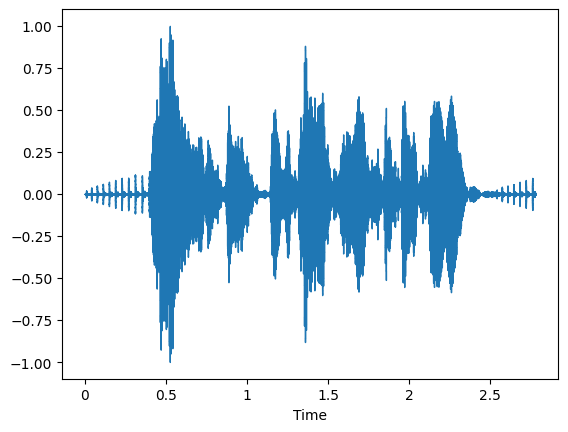

In [3]:
from observe_audio_function import plot_audio, listen_audio
y, sr = load_audio("./CH_fake_noise.wav", sr=SAMPLE_RATE)
listen_audio(y, sr) # 播放音訊
plot_audio(y,sr=sr) # 繪製音訊波形

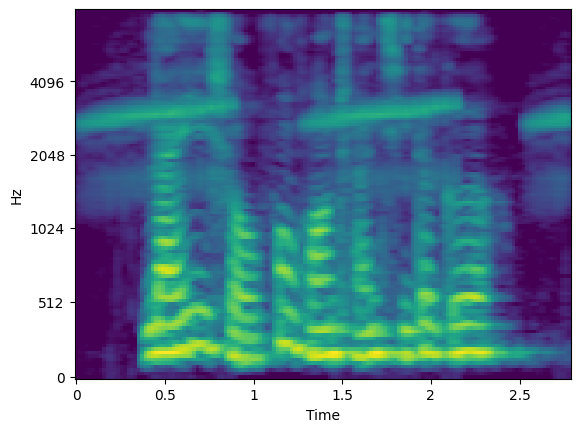

In [4]:
# 畫頻譜圖
spec = get_mel_spectrogram(y, sr)
plot_mel_spectrogram(spec)

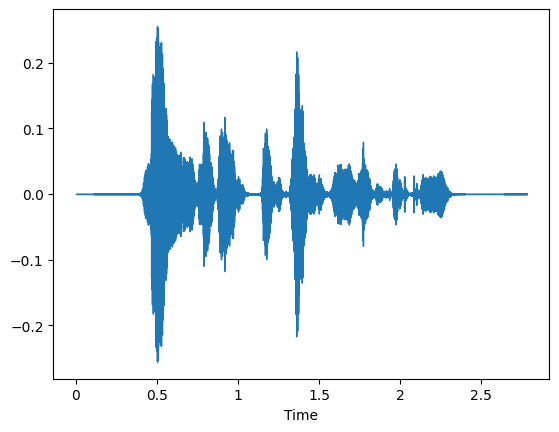

In [7]:
import noisereduce as nr
from observe_audio_function import listen_audio, denoise
import soundfile as sf
# 測試去除噪音
audio, sr = load_audio("./CH_fake_noise.wav", sr=SAMPLE_RATE)
reduced_noise = nr.reduce_noise(y=audio, sr=SAMPLE_RATE, stationary=True)
#eff = process_audio(reduced_noise, sr)
listen_audio(reduced_noise) # 播放音訊
plot_audio(reduced_noise,sr=sr) # 繪製音訊波形
# Specify the output file path
output_file = "CH_fake_denoise.wav"

# Write the audio file
sf.write(output_file, reduced_noise, sr)

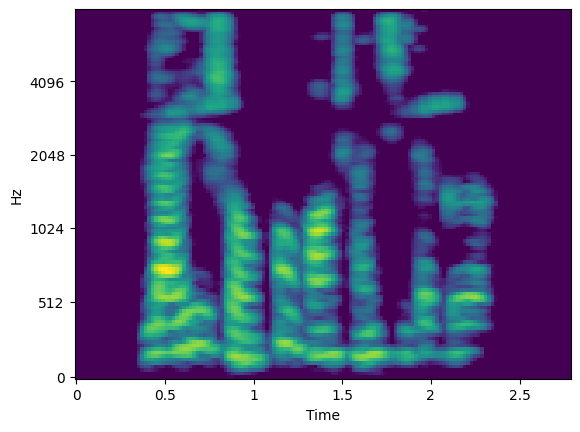

In [8]:
# 畫頻譜圖
spec2 = get_mel_spectrogram(reduced_noise, sr)
plot_mel_spectrogram(spec2)

#### 對gstreamer所記錄的語音進行測試

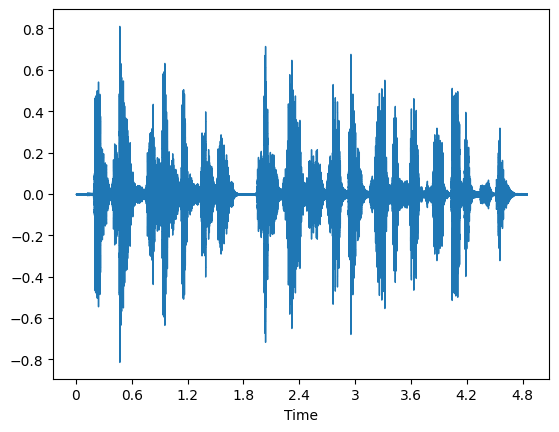

In [74]:
y, sr = load_audio("./alsasrc.ogg", sr=SAMPLE_RATE)
listen_audio(y, sr) # 播放音訊
plot_audio(y,sr=sr) # 繪製音訊波形

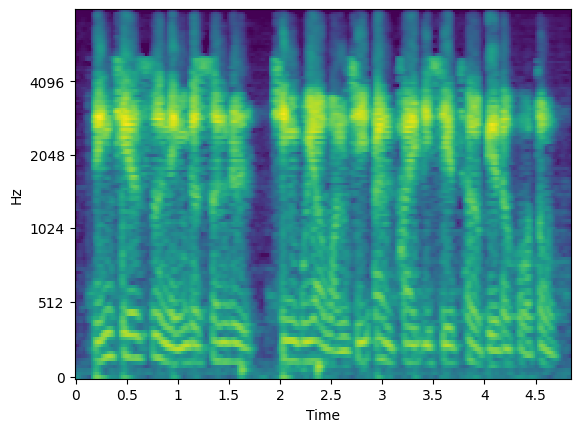

In [75]:
# 畫頻譜圖
spec = get_mel_spectrogram(y, sr)
plot_mel_spectrogram(spec)

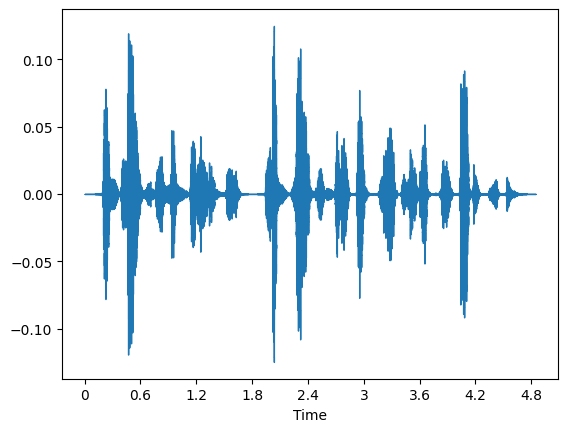

In [77]:
reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=True)
listen_audio(reduced_noise) # 播放音訊
plot_audio(reduced_noise,sr=sr) # 繪製音訊波形

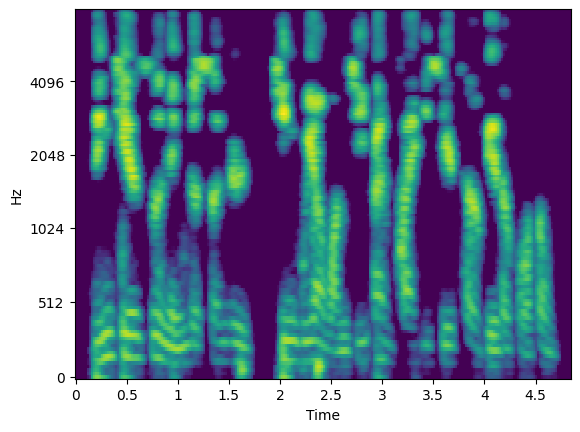

In [79]:
# 畫頻譜圖
spec = get_mel_spectrogram(reduced_noise, sr)
plot_mel_spectrogram(spec)

#### 無雜音

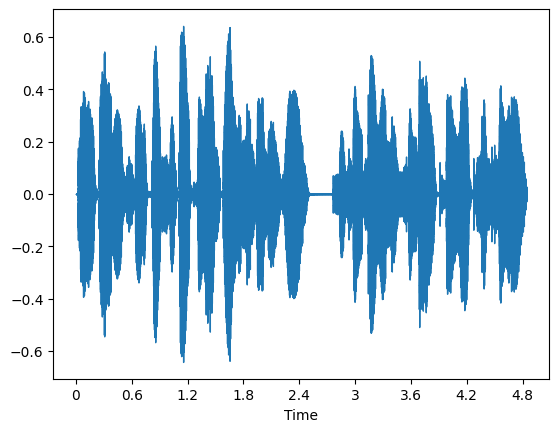

In [115]:
from observe_audio_function import plot_audio, listen_audio
y, sr = load_audio("./output (3).wav", sr=SAMPLE_RATE)
listen_audio(y, sr) # 播放音訊
plot_audio(y,sr=sr) # 繪製音訊波形

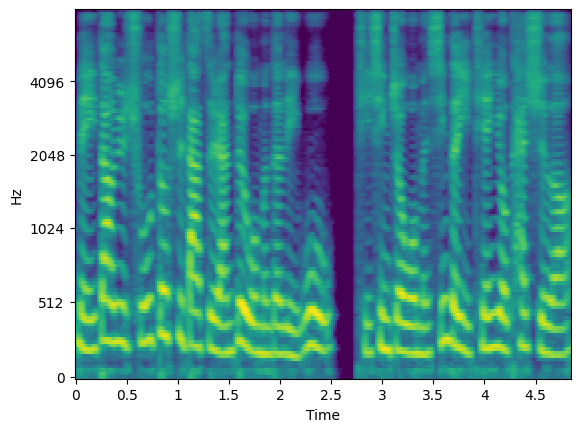

In [116]:
# 畫頻譜圖
spec = get_mel_spectrogram(y, sr)
plot_mel_spectrogram(spec)

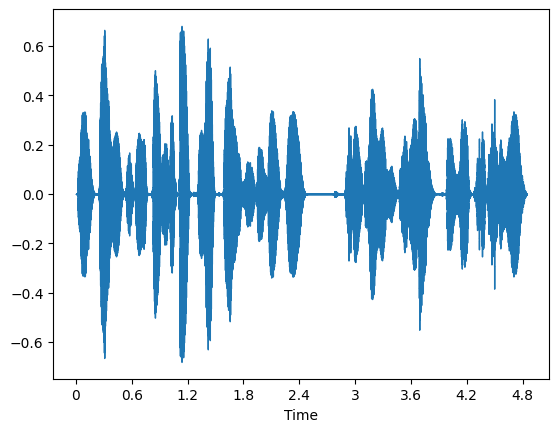

In [117]:
# 使用 noisereduce 庫降噪
reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=True)
edd =process_audio(reduced_noise, sr) # 處理音訊
listen_audio(edd) # 播放音訊
plot_audio(edd,sr=sr) # 繪製音訊波形

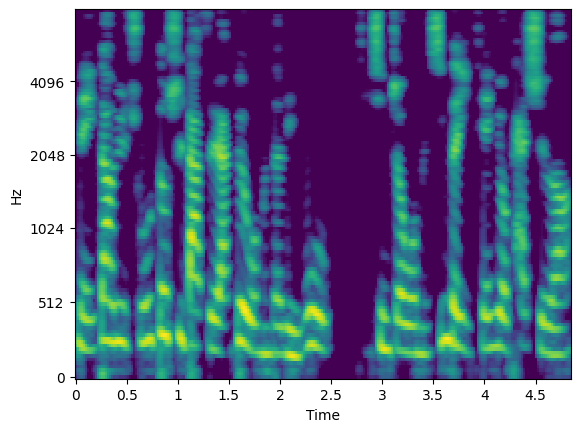

In [118]:
# 畫頻譜圖
spec = get_mel_spectrogram(edd, sr)
plot_mel_spectrogram(spec)

#### 結果
有達到去雜音的效果(以圖片來講)，但是並不是最初想像的去雜音(隔離出乾淨的聲音)  
另外，去除雜音的聲音會跟原本差不多

#### 新發現
stationary 這個參數多少會影響  
stationary=True: 假設噪音特性在整個音訊中是恆定的。  
stationary=False: 噪音特性可能會隨時間變化，會進行自適應噪音估計。  

#### pedalboard
也是處理音訊的library，這邊就仿造影片作法，來平衡音量大小